### Test Tabnet on Employee Attrition Data

In [1]:
import pandas as pd
import numpy as np
import ads

from ads import set_auth
from ads.model.generic_model import GenericModel

import torch
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.pretraining import TabNetPretrainer

from pytorch_tabnet.metrics import Metric

from sklearn.metrics import classification_report
from sklearn.metrics import get_scorer, make_scorer, f1_score
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

from ads.dataset.factory import DatasetFactory

import optuna

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import logging
import warnings

import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

%matplotlib inline

In [2]:
print(ads.__version__)

2.6.2


In [3]:
# set RP
set_auth(auth='resource_principal')

In [4]:
attrition_path = "/opt/notebooks/ads-examples/oracle_data/orcl_attrition.csv"

# uso ancora la classe dataset per fare l'upsampling

ds = DatasetFactory.open(
      attrition_path,
      target="Attrition").set_positive_class('Yes')

loop1:   0%|          | 0/4 [00:00<?, ?it/s]

In [5]:
# lavoro ancora sul dataset up sampled

ds_up = ds.up_sample()

In [6]:
cols_to_drop = ['Directs','name', 'Over18','WeeklyWorkedHours','EmployeeNumber']

ds_used = ds_up.drop(columns=cols_to_drop)

In [7]:
TARGET = 'Attrition'

features = list(set(ds_used.columns) - set([TARGET]))

features

['Age',
 'RelationshipSatisfaction',
 'EnvironmentSatisfaction',
 'YearsSinceLastPromotion',
 'YearsOnJob',
 'CommuteLength',
 'YearsWithCurrManager',
 'EducationField',
 'StockOptionLevel',
 'PerformanceRating',
 'JobInvolvement',
 'PercentSalaryHike',
 'WorkLifeBalance',
 'JobRole',
 'JobSatisfaction',
 'JobFunction',
 'JobLevel',
 'YearsinIndustry',
 'EducationalLevel',
 'OverTime',
 'Gender',
 'MaritalStatus',
 'TrainingTimesLastYear',
 'MonthlyRate',
 'NumCompaniesWorked',
 'TravelForWork',
 'HourlyRate',
 'YearsAtCurrentLevel',
 'MonthlyIncome',
 'SalaryLevel']

In [8]:
# take the Pandas DataFRame out

# versione differente di ADS (2.0... il metodo ha altro nome)
df_used = ds_used.to_pandas()

### lavorando direttamente senza AutoML dobbiamo provvedere noi a tutta la data preparation

In [9]:
THR = 10

nunique = df_used.nunique()
types = df_used.dtypes

categorical_columns = []
categorical_dims =  {}
for col in df_used.columns:
    
    # identifichiamo come categoriche tutte le colonne che soddisfano questa condizione !!!
    # la soglia la possiamo cambiare
    if types[col] == 'object' or nunique[col] < THR:
        print(col, df_used[col].nunique())
        
        # codifichiamo i categorici con LabelEncoder
        l_enc = LabelEncoder()
        df_used[col] = l_enc.fit_transform(df_used[col].values)
        
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)

TravelForWork 3
JobFunction 3
EducationalLevel 5
EducationField 6
EnvironmentSatisfaction 4
Gender 2
JobInvolvement 4
JobLevel 5
JobRole 9
JobSatisfaction 4
MaritalStatus 3
OverTime 2
PerformanceRating 2
RelationshipSatisfaction 4
StockOptionLevel 4
TrainingTimesLastYear 7
WorkLifeBalance 4
Attrition 2


In [10]:
cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

In [11]:
# now we have codified everything, are ready

In [12]:
X = df_used[features].values
y = df_used[TARGET].values

X.shape

(2466, 30)

In [13]:
# train, test split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.2, random_state = 1234)

print("# of samples in train set", X_train.shape[0])
print("# of samples in test set", X_test.shape[0])

# of samples in train set 1972
# of samples in test set 494


In [14]:
#
# if we need F we need a custom implementation for F1 in Tabnet
#
class F1(Metric):
    def __init__(self):
        self._name = "f1"
        self._maximize = True
        # potremmo lavorare siu questa soglia
        self.thr = 0.55
    
    # the input are probs, must be converted to 0, 1
    def __call__(self, y_true, p_score):
        
        # here we have labels
        y_score = (p_score[:, 1] >= self.thr).astype(int)
        
        return f1_score(y_true, y_score)

In [15]:
%%time
# see: https://github.com/dreamquark-ai/tabnet

# TabNetPretrainer
unsupervised_model = TabNetPretrainer(
    cat_idxs=cat_idxs,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    mask_type='entmax' # "sparsemax"
)

unsupervised_model.fit(
    X_train=X_train,
    eval_set=[X_test],
    pretraining_ratio=0.6,
    max_epochs = 200,
)

Device used : cpu
epoch 0  | loss: 5.66424 | val_0_unsup_loss: 152.56284|  0:00:00s
epoch 1  | loss: 4.73093 | val_0_unsup_loss: 28.84589|  0:00:00s
epoch 2  | loss: 4.17575 | val_0_unsup_loss: 18.70724|  0:00:00s
epoch 3  | loss: 3.84144 | val_0_unsup_loss: 14.54688|  0:00:01s
epoch 4  | loss: 3.59719 | val_0_unsup_loss: 9.37707 |  0:00:01s
epoch 5  | loss: 3.34794 | val_0_unsup_loss: 6.18216 |  0:00:01s
epoch 6  | loss: 3.19214 | val_0_unsup_loss: 5.17996 |  0:00:02s
epoch 7  | loss: 3.07507 | val_0_unsup_loss: 4.57977 |  0:00:02s
epoch 8  | loss: 2.96759 | val_0_unsup_loss: 4.19723 |  0:00:02s
epoch 9  | loss: 2.89597 | val_0_unsup_loss: 3.89183 |  0:00:03s
epoch 10 | loss: 2.7846  | val_0_unsup_loss: 3.69231 |  0:00:03s
epoch 11 | loss: 2.71172 | val_0_unsup_loss: 3.31038 |  0:00:03s
epoch 12 | loss: 2.61945 | val_0_unsup_loss: 2.87133 |  0:00:04s
epoch 13 | loss: 2.60973 | val_0_unsup_loss: 2.73098 |  0:00:04s
epoch 14 | loss: 2.48826 | val_0_unsup_loss: 2.63852 |  0:00:04s
epoch 

In [16]:
#
# In questo caso ho preferito utilizzare direttamente Optuna (su cui è basato ADSTuner)
#

# split in due parti la seconda ottimizzo con Optuna

# la valutazione la facciamo sull'accuracy

def objective(trial):
    n_steps = trial.suggest_int("n_steps", 1, 10)
    gamma = trial.suggest_float("gamma", 1.0, 2.0)
    
    params = {
        "cat_idxs" : cat_idxs,
        "cat_dims" : cat_dims,
        "n_steps" : n_steps,
        "gamma" : gamma,
        "seed" : 0,
        "verbose" : 10
    }
    clf = TabNetClassifier(**params)

    clf.fit(
        X_train=X_train, y_train=y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        eval_name=['train', 'valid'],
        eval_metric=['auc', 'accuracy'],
        from_unsupervised=unsupervised_model,
        batch_size=128, 
        max_epochs = 100
    )
    
    y_pred = clf.predict(X_test)
    
    return round(accuracy_score(y_test, y_pred), 5)

In [17]:
#
# create an launch the study
#
study = optuna.create_study(direction="maximize")

study.optimize(objective, n_trials=20)

[I 2022-10-15 17:00:16,267] A new study created in memory with name: no-name-2ac1b5f0-1d50-4b8a-bab7-d33506a13f3a


Device used : cpu
Loading weights from unsupervised pretraining
epoch 0  | loss: 0.97616 | train_auc: 0.63895 | train_accuracy: 0.60801 | valid_auc: 0.66932 | valid_accuracy: 0.63158 |  0:00:00s
epoch 10 | loss: 0.2997  | train_auc: 0.94847 | train_accuracy: 0.86258 | valid_auc: 0.90467 | valid_accuracy: 0.81174 |  0:00:09s
epoch 20 | loss: 0.15976 | train_auc: 0.98759 | train_accuracy: 0.9498  | valid_auc: 0.95827 | valid_accuracy: 0.91903 |  0:00:17s
epoch 30 | loss: 0.10753 | train_auc: 0.99003 | train_accuracy: 0.96197 | valid_auc: 0.94254 | valid_accuracy: 0.89676 |  0:00:25s
epoch 40 | loss: 0.08846 | train_auc: 0.99782 | train_accuracy: 0.98732 | valid_auc: 0.9619  | valid_accuracy: 0.92308 |  0:00:33s


[I 2022-10-15 17:00:55,270] Trial 0 finished with value: 0.9413 and parameters: {'n_steps': 8, 'gamma': 1.8725234362839414}. Best is trial 0 with value: 0.9413.



Early stopping occurred at epoch 46 with best_epoch = 36 and best_valid_accuracy = 0.9413
Best weights from best epoch are automatically used!
Device used : cpu
Loading weights from unsupervised pretraining
epoch 0  | loss: 0.96535 | train_auc: 0.5901  | train_accuracy: 0.55122 | valid_auc: 0.57309 | valid_accuracy: 0.54656 |  0:00:00s
epoch 10 | loss: 0.34684 | train_auc: 0.88402 | train_accuracy: 0.75507 | valid_auc: 0.83511 | valid_accuracy: 0.7166  |  0:00:06s
epoch 20 | loss: 0.19646 | train_auc: 0.98657 | train_accuracy: 0.94625 | valid_auc: 0.95064 | valid_accuracy: 0.89271 |  0:00:12s
epoch 30 | loss: 0.09534 | train_auc: 0.99682 | train_accuracy: 0.98327 | valid_auc: 0.97289 | valid_accuracy: 0.91903 |  0:00:18s
epoch 40 | loss: 0.07076 | train_auc: 0.99833 | train_accuracy: 0.9858  | valid_auc: 0.96779 | valid_accuracy: 0.90081 |  0:00:24s

Early stopping occurred at epoch 47 with best_epoch = 37 and best_valid_accuracy = 0.93927
Best weights from best epoch are automaticall

[I 2022-10-15 17:01:25,246] Trial 1 finished with value: 0.93927 and parameters: {'n_steps': 5, 'gamma': 1.7518298382116477}. Best is trial 0 with value: 0.9413.


Device used : cpu
Loading weights from unsupervised pretraining
epoch 0  | loss: 0.99395 | train_auc: 0.66257 | train_accuracy: 0.53347 | valid_auc: 0.67167 | valid_accuracy: 0.51215 |  0:00:00s
epoch 10 | loss: 0.2603  | train_auc: 0.96591 | train_accuracy: 0.83976 | valid_auc: 0.91814 | valid_accuracy: 0.81781 |  0:00:09s
epoch 20 | loss: 0.19964 | train_auc: 0.9897  | train_accuracy: 0.95132 | valid_auc: 0.95932 | valid_accuracy: 0.89474 |  0:00:17s
epoch 30 | loss: 0.13474 | train_auc: 0.99733 | train_accuracy: 0.97515 | valid_auc: 0.94533 | valid_accuracy: 0.88866 |  0:00:25s

Early stopping occurred at epoch 30 with best_epoch = 20 and best_valid_accuracy = 0.89474
Best weights from best epoch are automatically used!


[I 2022-10-15 17:01:51,346] Trial 2 finished with value: 0.89474 and parameters: {'n_steps': 2, 'gamma': 1.6960011822816585}. Best is trial 0 with value: 0.9413.


Device used : cpu
Loading weights from unsupervised pretraining
epoch 0  | loss: 0.9798  | train_auc: 0.66214 | train_accuracy: 0.62931 | valid_auc: 0.65834 | valid_accuracy: 0.62551 |  0:00:00s
epoch 10 | loss: 0.30207 | train_auc: 0.94105 | train_accuracy: 0.83671 | valid_auc: 0.92378 | valid_accuracy: 0.82389 |  0:00:09s
epoch 20 | loss: 0.20397 | train_auc: 0.98417 | train_accuracy: 0.91988 | valid_auc: 0.95367 | valid_accuracy: 0.88866 |  0:00:17s
epoch 30 | loss: 0.13857 | train_auc: 0.98978 | train_accuracy: 0.95385 | valid_auc: 0.95562 | valid_accuracy: 0.90081 |  0:00:25s

Early stopping occurred at epoch 34 with best_epoch = 24 and best_valid_accuracy = 0.91498
Best weights from best epoch are automatically used!


[I 2022-10-15 17:02:20,714] Trial 3 finished with value: 0.91498 and parameters: {'n_steps': 3, 'gamma': 1.866590033178265}. Best is trial 0 with value: 0.9413.


Device used : cpu
Loading weights from unsupervised pretraining
epoch 0  | loss: 0.98672 | train_auc: 0.66453 | train_accuracy: 0.62779 | valid_auc: 0.70363 | valid_accuracy: 0.65789 |  0:00:00s
epoch 10 | loss: 0.28983 | train_auc: 0.9468  | train_accuracy: 0.85345 | valid_auc: 0.88214 | valid_accuracy: 0.81174 |  0:00:08s
epoch 20 | loss: 0.18651 | train_auc: 0.98219 | train_accuracy: 0.92698 | valid_auc: 0.93214 | valid_accuracy: 0.87247 |  0:00:17s
epoch 30 | loss: 0.11161 | train_auc: 0.99505 | train_accuracy: 0.97363 | valid_auc: 0.95777 | valid_accuracy: 0.90486 |  0:00:25s
epoch 40 | loss: 0.07168 | train_auc: 0.99851 | train_accuracy: 0.98783 | valid_auc: 0.96651 | valid_accuracy: 0.93522 |  0:00:33s

Early stopping occurred at epoch 48 with best_epoch = 38 and best_valid_accuracy = 0.93522
Best weights from best epoch are automatically used!


[I 2022-10-15 17:03:01,275] Trial 4 finished with value: 0.93522 and parameters: {'n_steps': 3, 'gamma': 1.759397797081231}. Best is trial 0 with value: 0.9413.


Device used : cpu
Loading weights from unsupervised pretraining
epoch 0  | loss: 0.97986 | train_auc: 0.68851 | train_accuracy: 0.63387 | valid_auc: 0.71245 | valid_accuracy: 0.65587 |  0:00:00s
epoch 10 | loss: 0.30374 | train_auc: 0.94394 | train_accuracy: 0.82049 | valid_auc: 0.90838 | valid_accuracy: 0.78947 |  0:00:06s
epoch 20 | loss: 0.15546 | train_auc: 0.99297 | train_accuracy: 0.964   | valid_auc: 0.95888 | valid_accuracy: 0.89676 |  0:00:12s
epoch 30 | loss: 0.10235 | train_auc: 0.99232 | train_accuracy: 0.97059 | valid_auc: 0.94851 | valid_accuracy: 0.91093 |  0:00:18s


[I 2022-10-15 17:03:23,496] Trial 5 finished with value: 0.92713 and parameters: {'n_steps': 3, 'gamma': 1.4980657059687785}. Best is trial 0 with value: 0.9413.



Early stopping occurred at epoch 35 with best_epoch = 25 and best_valid_accuracy = 0.92713
Best weights from best epoch are automatically used!
Device used : cpu
Loading weights from unsupervised pretraining
epoch 0  | loss: 0.97052 | train_auc: 0.65768 | train_accuracy: 0.58874 | valid_auc: 0.68426 | valid_accuracy: 0.6336  |  0:00:00s
epoch 10 | loss: 0.30983 | train_auc: 0.92148 | train_accuracy: 0.83316 | valid_auc: 0.85771 | valid_accuracy: 0.76113 |  0:00:06s
epoch 20 | loss: 0.16662 | train_auc: 0.99125 | train_accuracy: 0.94422 | valid_auc: 0.94162 | valid_accuracy: 0.88057 |  0:00:12s
epoch 30 | loss: 0.12263 | train_auc: 0.99781 | train_accuracy: 0.98377 | valid_auc: 0.96887 | valid_accuracy: 0.90486 |  0:00:18s
epoch 40 | loss: 0.09884 | train_auc: 0.99875 | train_accuracy: 0.98631 | valid_auc: 0.96836 | valid_accuracy: 0.91296 |  0:00:24s


[I 2022-10-15 17:03:52,674] Trial 6 finished with value: 0.93927 and parameters: {'n_steps': 8, 'gamma': 1.4499484875432538}. Best is trial 0 with value: 0.9413.



Early stopping occurred at epoch 47 with best_epoch = 37 and best_valid_accuracy = 0.93927
Best weights from best epoch are automatically used!
Device used : cpu
Loading weights from unsupervised pretraining
epoch 0  | loss: 0.98369 | train_auc: 0.62368 | train_accuracy: 0.57404 | valid_auc: 0.63232 | valid_accuracy: 0.59919 |  0:00:00s
epoch 10 | loss: 0.35987 | train_auc: 0.91856 | train_accuracy: 0.83012 | valid_auc: 0.89187 | valid_accuracy: 0.79757 |  0:00:06s
epoch 20 | loss: 0.2535  | train_auc: 0.97559 | train_accuracy: 0.93712 | valid_auc: 0.91121 | valid_accuracy: 0.85628 |  0:00:12s
epoch 30 | loss: 0.13659 | train_auc: 0.99282 | train_accuracy: 0.97008 | valid_auc: 0.95373 | valid_accuracy: 0.89474 |  0:00:18s
epoch 40 | loss: 0.09411 | train_auc: 0.9982  | train_accuracy: 0.9858  | valid_auc: 0.95097 | valid_accuracy: 0.92308 |  0:00:24s
epoch 50 | loss: 0.07934 | train_auc: 0.99894 | train_accuracy: 0.99138 | valid_auc: 0.94794 | valid_accuracy: 0.90283 |  0:00:30s


[I 2022-10-15 17:04:26,714] Trial 7 finished with value: 0.9251 and parameters: {'n_steps': 2, 'gamma': 1.710790308910979}. Best is trial 0 with value: 0.9413.



Early stopping occurred at epoch 55 with best_epoch = 45 and best_valid_accuracy = 0.9251
Best weights from best epoch are automatically used!
Device used : cpu
Loading weights from unsupervised pretraining
epoch 0  | loss: 0.97811 | train_auc: 0.67063 | train_accuracy: 0.59635 | valid_auc: 0.69822 | valid_accuracy: 0.62753 |  0:00:00s
epoch 10 | loss: 0.28956 | train_auc: 0.91848 | train_accuracy: 0.80375 | valid_auc: 0.87213 | valid_accuracy: 0.76721 |  0:00:06s
epoch 20 | loss: 0.17903 | train_auc: 0.98782 | train_accuracy: 0.9498  | valid_auc: 0.95476 | valid_accuracy: 0.88057 |  0:00:12s
epoch 30 | loss: 0.08411 | train_auc: 0.99923 | train_accuracy: 0.98732 | valid_auc: 0.97178 | valid_accuracy: 0.9251  |  0:00:18s
epoch 40 | loss: 0.09581 | train_auc: 0.99977 | train_accuracy: 0.99391 | valid_auc: 0.96554 | valid_accuracy: 0.9251  |  0:00:24s

Early stopping occurred at epoch 40 with best_epoch = 30 and best_valid_accuracy = 0.9251
Best weights from best epoch are automatically

[I 2022-10-15 17:04:51,850] Trial 8 finished with value: 0.9251 and parameters: {'n_steps': 6, 'gamma': 1.4460082516316772}. Best is trial 0 with value: 0.9413.


Device used : cpu
Loading weights from unsupervised pretraining
epoch 0  | loss: 0.98345 | train_auc: 0.67281 | train_accuracy: 0.60548 | valid_auc: 0.68209 | valid_accuracy: 0.62955 |  0:00:00s
epoch 10 | loss: 0.25671 | train_auc: 0.93378 | train_accuracy: 0.8286  | valid_auc: 0.92055 | valid_accuracy: 0.81984 |  0:00:06s
epoch 20 | loss: 0.13677 | train_auc: 0.98926 | train_accuracy: 0.9498  | valid_auc: 0.96247 | valid_accuracy: 0.91296 |  0:00:12s
epoch 30 | loss: 0.09316 | train_auc: 0.99735 | train_accuracy: 0.97769 | valid_auc: 0.96686 | valid_accuracy: 0.92915 |  0:00:18s
epoch 40 | loss: 0.06155 | train_auc: 0.99851 | train_accuracy: 0.98529 | valid_auc: 0.97032 | valid_accuracy: 0.93522 |  0:00:24s

Early stopping occurred at epoch 49 with best_epoch = 39 and best_valid_accuracy = 0.94332
Best weights from best epoch are automatically used!


[I 2022-10-15 17:05:22,414] Trial 9 finished with value: 0.94332 and parameters: {'n_steps': 1, 'gamma': 1.0635116130558702}. Best is trial 9 with value: 0.94332.


Device used : cpu
Loading weights from unsupervised pretraining
epoch 0  | loss: 0.97524 | train_auc: 0.66669 | train_accuracy: 0.61663 | valid_auc: 0.67269 | valid_accuracy: 0.62146 |  0:00:00s
epoch 10 | loss: 0.28725 | train_auc: 0.93393 | train_accuracy: 0.83621 | valid_auc: 0.89717 | valid_accuracy: 0.79555 |  0:00:06s
epoch 20 | loss: 0.17918 | train_auc: 0.99424 | train_accuracy: 0.95842 | valid_auc: 0.96019 | valid_accuracy: 0.89676 |  0:00:12s
epoch 30 | loss: 0.10955 | train_auc: 0.99505 | train_accuracy: 0.97059 | valid_auc: 0.95148 | valid_accuracy: 0.89474 |  0:00:18s


[I 2022-10-15 17:05:43,242] Trial 10 finished with value: 0.91903 and parameters: {'n_steps': 10, 'gamma': 1.0427327149355554}. Best is trial 9 with value: 0.94332.



Early stopping occurred at epoch 33 with best_epoch = 23 and best_valid_accuracy = 0.91903
Best weights from best epoch are automatically used!
Device used : cpu
Loading weights from unsupervised pretraining
epoch 0  | loss: 0.98713 | train_auc: 0.663   | train_accuracy: 0.59178 | valid_auc: 0.67991 | valid_accuracy: 0.57085 |  0:00:00s
epoch 10 | loss: 0.25616 | train_auc: 0.94499 | train_accuracy: 0.83012 | valid_auc: 0.91871 | valid_accuracy: 0.81579 |  0:00:06s
epoch 20 | loss: 0.14632 | train_auc: 0.9953  | train_accuracy: 0.96755 | valid_auc: 0.96566 | valid_accuracy: 0.90688 |  0:00:12s
epoch 30 | loss: 0.09205 | train_auc: 0.99647 | train_accuracy: 0.98276 | valid_auc: 0.97243 | valid_accuracy: 0.90486 |  0:00:18s

Early stopping occurred at epoch 33 with best_epoch = 23 and best_valid_accuracy = 0.93117
Best weights from best epoch are automatically used!


[I 2022-10-15 17:06:04,048] Trial 11 finished with value: 0.93117 and parameters: {'n_steps': 8, 'gamma': 1.0457472162748231}. Best is trial 9 with value: 0.94332.


Device used : cpu
Loading weights from unsupervised pretraining
epoch 0  | loss: 0.98706 | train_auc: 0.66115 | train_accuracy: 0.61359 | valid_auc: 0.66265 | valid_accuracy: 0.61741 |  0:00:00s
epoch 10 | loss: 0.30091 | train_auc: 0.94418 | train_accuracy: 0.83469 | valid_auc: 0.89171 | valid_accuracy: 0.77935 |  0:00:06s
epoch 20 | loss: 0.16826 | train_auc: 0.9888  | train_accuracy: 0.94726 | valid_auc: 0.93824 | valid_accuracy: 0.86437 |  0:00:12s

Early stopping occurred at epoch 28 with best_epoch = 18 and best_valid_accuracy = 0.90891
Best weights from best epoch are automatically used!


[I 2022-10-15 17:06:21,847] Trial 12 finished with value: 0.90891 and parameters: {'n_steps': 6, 'gamma': 1.2393339318015644}. Best is trial 9 with value: 0.94332.


Device used : cpu
Loading weights from unsupervised pretraining
epoch 0  | loss: 0.97843 | train_auc: 0.64395 | train_accuracy: 0.59128 | valid_auc: 0.64545 | valid_accuracy: 0.58097 |  0:00:00s
epoch 10 | loss: 0.41241 | train_auc: 0.92024 | train_accuracy: 0.84483 | valid_auc: 0.87586 | valid_accuracy: 0.78947 |  0:00:06s
epoch 20 | loss: 0.22772 | train_auc: 0.98314 | train_accuracy: 0.94219 | valid_auc: 0.94003 | valid_accuracy: 0.88057 |  0:00:12s
epoch 30 | loss: 0.12875 | train_auc: 0.99392 | train_accuracy: 0.96045 | valid_auc: 0.94469 | valid_accuracy: 0.87247 |  0:00:18s

Early stopping occurred at epoch 30 with best_epoch = 20 and best_valid_accuracy = 0.88057
Best weights from best epoch are automatically used!


[I 2022-10-15 17:06:40,940] Trial 13 finished with value: 0.88057 and parameters: {'n_steps': 8, 'gamma': 1.9772624629065982}. Best is trial 9 with value: 0.94332.


Device used : cpu
Loading weights from unsupervised pretraining
epoch 0  | loss: 0.98725 | train_auc: 0.71222 | train_accuracy: 0.65264 | valid_auc: 0.7258  | valid_accuracy: 0.66599 |  0:00:00s
epoch 10 | loss: 0.27587 | train_auc: 0.9443  | train_accuracy: 0.83012 | valid_auc: 0.89262 | valid_accuracy: 0.78947 |  0:00:06s
epoch 20 | loss: 0.17354 | train_auc: 0.98936 | train_accuracy: 0.93002 | valid_auc: 0.94904 | valid_accuracy: 0.88057 |  0:00:12s
epoch 30 | loss: 0.11191 | train_auc: 0.99665 | train_accuracy: 0.98377 | valid_auc: 0.95416 | valid_accuracy: 0.93117 |  0:00:18s
epoch 40 | loss: 0.05647 | train_auc: 0.99762 | train_accuracy: 0.98225 | valid_auc: 0.95991 | valid_accuracy: 0.92308 |  0:00:24s


[I 2022-10-15 17:07:10,725] Trial 14 finished with value: 0.93927 and parameters: {'n_steps': 1, 'gamma': 1.2670112537941498}. Best is trial 9 with value: 0.94332.



Early stopping occurred at epoch 48 with best_epoch = 38 and best_valid_accuracy = 0.93927
Best weights from best epoch are automatically used!
Device used : cpu
Loading weights from unsupervised pretraining
epoch 0  | loss: 0.98487 | train_auc: 0.66423 | train_accuracy: 0.61207 | valid_auc: 0.67548 | valid_accuracy: 0.62955 |  0:00:00s
epoch 10 | loss: 0.27103 | train_auc: 0.94792 | train_accuracy: 0.87627 | valid_auc: 0.91463 | valid_accuracy: 0.84413 |  0:00:06s
epoch 20 | loss: 0.18561 | train_auc: 0.98346 | train_accuracy: 0.93763 | valid_auc: 0.94593 | valid_accuracy: 0.88866 |  0:00:12s
epoch 30 | loss: 0.13296 | train_auc: 0.99568 | train_accuracy: 0.97312 | valid_auc: 0.96261 | valid_accuracy: 0.88462 |  0:00:18s


[I 2022-10-15 17:07:32,659] Trial 15 finished with value: 0.91498 and parameters: {'n_steps': 10, 'gamma': 1.2608043255932604}. Best is trial 9 with value: 0.94332.



Early stopping occurred at epoch 35 with best_epoch = 25 and best_valid_accuracy = 0.91498
Best weights from best epoch are automatically used!
Device used : cpu
Loading weights from unsupervised pretraining
epoch 0  | loss: 0.98708 | train_auc: 0.63255 | train_accuracy: 0.6141  | valid_auc: 0.63546 | valid_accuracy: 0.62348 |  0:00:00s
epoch 10 | loss: 0.33199 | train_auc: 0.93142 | train_accuracy: 0.81034 | valid_auc: 0.87356 | valid_accuracy: 0.76316 |  0:00:06s
epoch 20 | loss: 0.22411 | train_auc: 0.97485 | train_accuracy: 0.92191 | valid_auc: 0.90923 | valid_accuracy: 0.84008 |  0:00:12s
epoch 30 | loss: 0.14224 | train_auc: 0.9922  | train_accuracy: 0.96045 | valid_auc: 0.93973 | valid_accuracy: 0.88462 |  0:00:18s
epoch 40 | loss: 0.08942 | train_auc: 0.99737 | train_accuracy: 0.98225 | valid_auc: 0.95265 | valid_accuracy: 0.90688 |  0:00:24s


[I 2022-10-15 17:07:58,336] Trial 16 finished with value: 0.92308 and parameters: {'n_steps': 5, 'gamma': 1.6004522243450916}. Best is trial 9 with value: 0.94332.



Early stopping occurred at epoch 41 with best_epoch = 31 and best_valid_accuracy = 0.92308
Best weights from best epoch are automatically used!
Device used : cpu
Loading weights from unsupervised pretraining
epoch 0  | loss: 0.97931 | train_auc: 0.64822 | train_accuracy: 0.59686 | valid_auc: 0.64053 | valid_accuracy: 0.5668  |  0:00:00s
epoch 10 | loss: 0.36312 | train_auc: 0.92731 | train_accuracy: 0.84381 | valid_auc: 0.87802 | valid_accuracy: 0.80567 |  0:00:06s
epoch 20 | loss: 0.18759 | train_auc: 0.98544 | train_accuracy: 0.93763 | valid_auc: 0.94846 | valid_accuracy: 0.87652 |  0:00:12s
epoch 30 | loss: 0.1133  | train_auc: 0.99687 | train_accuracy: 0.98124 | valid_auc: 0.95735 | valid_accuracy: 0.91296 |  0:00:18s
epoch 40 | loss: 0.09509 | train_auc: 0.99849 | train_accuracy: 0.98327 | valid_auc: 0.97107 | valid_accuracy: 0.9332  |  0:00:24s
epoch 50 | loss: 0.08628 | train_auc: 0.99885 | train_accuracy: 0.98377 | valid_auc: 0.95583 | valid_accuracy: 0.89879 |  0:00:30s
epoch

[I 2022-10-15 17:08:42,404] Trial 17 finished with value: 0.95142 and parameters: {'n_steps': 7, 'gamma': 1.9776686139665465}. Best is trial 17 with value: 0.95142.



Early stopping occurred at epoch 72 with best_epoch = 62 and best_valid_accuracy = 0.95142
Best weights from best epoch are automatically used!
Device used : cpu
Loading weights from unsupervised pretraining
epoch 0  | loss: 0.98184 | train_auc: 0.65338 | train_accuracy: 0.56795 | valid_auc: 0.65879 | valid_accuracy: 0.57692 |  0:00:00s
epoch 10 | loss: 0.28151 | train_auc: 0.90859 | train_accuracy: 0.72566 | valid_auc: 0.85487 | valid_accuracy: 0.71457 |  0:00:06s
epoch 20 | loss: 0.16547 | train_auc: 0.98366 | train_accuracy: 0.94422 | valid_auc: 0.92716 | valid_accuracy: 0.87247 |  0:00:12s
epoch 30 | loss: 0.11243 | train_auc: 0.99529 | train_accuracy: 0.97515 | valid_auc: 0.95489 | valid_accuracy: 0.89879 |  0:00:18s
epoch 40 | loss: 0.08304 | train_auc: 0.9985  | train_accuracy: 0.98834 | valid_auc: 0.95996 | valid_accuracy: 0.90891 |  0:00:24s


[I 2022-10-15 17:09:09,860] Trial 18 finished with value: 0.93522 and parameters: {'n_steps': 7, 'gamma': 1.16292996388161}. Best is trial 17 with value: 0.95142.



Early stopping occurred at epoch 44 with best_epoch = 34 and best_valid_accuracy = 0.93522
Best weights from best epoch are automatically used!
Device used : cpu
Loading weights from unsupervised pretraining
epoch 0  | loss: 0.96652 | train_auc: 0.62757 | train_accuracy: 0.59939 | valid_auc: 0.64351 | valid_accuracy: 0.62146 |  0:00:00s
epoch 10 | loss: 0.2762  | train_auc: 0.94689 | train_accuracy: 0.83722 | valid_auc: 0.86839 | valid_accuracy: 0.76316 |  0:00:06s
epoch 20 | loss: 0.13599 | train_auc: 0.99057 | train_accuracy: 0.96501 | valid_auc: 0.93397 | valid_accuracy: 0.87652 |  0:00:12s
epoch 30 | loss: 0.08562 | train_auc: 0.99752 | train_accuracy: 0.98174 | valid_auc: 0.95809 | valid_accuracy: 0.89474 |  0:00:18s
epoch 40 | loss: 0.0953  | train_auc: 0.99868 | train_accuracy: 0.98631 | valid_auc: 0.95365 | valid_accuracy: 0.90688 |  0:00:24s
epoch 50 | loss: 0.05699 | train_auc: 0.99979 | train_accuracy: 0.99239 | valid_auc: 0.9664  | valid_accuracy: 0.9251  |  0:00:30s
epoch

[I 2022-10-15 17:09:47,943] Trial 19 finished with value: 0.92915 and parameters: {'n_steps': 4, 'gamma': 1.3730657006983227}. Best is trial 17 with value: 0.95142.



Early stopping occurred at epoch 61 with best_epoch = 51 and best_valid_accuracy = 0.92915
Best weights from best epoch are automatically used!


In [18]:
study.best_params

{'n_steps': 7, 'gamma': 1.9776686139665465}

In [19]:
# train with best params: {'n_steps': 6, 'gamma': 1.823432125206781}
# il risultato è riproducibile

params = {
    "cat_idxs" : cat_idxs,
    "cat_dims" : cat_dims,
    "n_steps" : study.best_params['n_steps'],
    "gamma" : study.best_params['gamma'],
    "verbose" : 5
    }
clf = TabNetClassifier(**params)

clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    eval_name=['train', 'valid'],
    eval_metric=['auc', 'accuracy'],
    from_unsupervised=unsupervised_model,
    batch_size=128, 
    max_epochs = 50
)

Device used : cpu
Loading weights from unsupervised pretraining
epoch 0  | loss: 0.97931 | train_auc: 0.64822 | train_accuracy: 0.59686 | valid_auc: 0.64053 | valid_accuracy: 0.5668  |  0:00:00s
epoch 5  | loss: 0.52538 | train_auc: 0.76492 | train_accuracy: 0.62728 | valid_auc: 0.75119 | valid_accuracy: 0.61741 |  0:00:04s
epoch 10 | loss: 0.36312 | train_auc: 0.92731 | train_accuracy: 0.84381 | valid_auc: 0.87802 | valid_accuracy: 0.80567 |  0:00:09s
epoch 15 | loss: 0.27696 | train_auc: 0.96942 | train_accuracy: 0.90822 | valid_auc: 0.90728 | valid_accuracy: 0.80364 |  0:00:13s
epoch 20 | loss: 0.18759 | train_auc: 0.98544 | train_accuracy: 0.93763 | valid_auc: 0.94846 | valid_accuracy: 0.87652 |  0:00:17s
epoch 25 | loss: 0.17945 | train_auc: 0.98938 | train_accuracy: 0.95385 | valid_auc: 0.94393 | valid_accuracy: 0.88866 |  0:00:21s
epoch 30 | loss: 0.1133  | train_auc: 0.99687 | train_accuracy: 0.98124 | valid_auc: 0.95735 | valid_accuracy: 0.91296 |  0:00:25s
epoch 35 | loss: 0.

In [20]:
# migliorata significativamente con la gestione delle categoriche e sopratutto pre-training

test_pred = clf.predict(X_test)
test_probas = clf.predict_proba(X_test)

print('Test set Classification Report:')
print(classification_report(y_test, test_pred, digits=4))

print("ROC AUC",round(roc_auc_score(y_test, test_probas[:,1]), 3))

Test set Classification Report:
              precision    recall  f1-score   support

           0     0.9785    0.8941    0.9344       255
           1     0.8966    0.9791    0.9360       239

    accuracy                         0.9352       494
   macro avg     0.9375    0.9366    0.9352       494
weighted avg     0.9389    0.9352    0.9352       494

ROC AUC 0.972


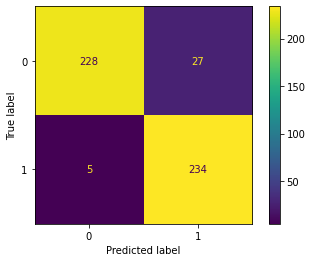

In [21]:
def plot_cm(model, x_test, y_test):
    y_pred_labels = model.predict(x_test)
    cm = confusion_matrix(y_test, y_pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot();
    
plot_cm(clf, X_test, y_test)

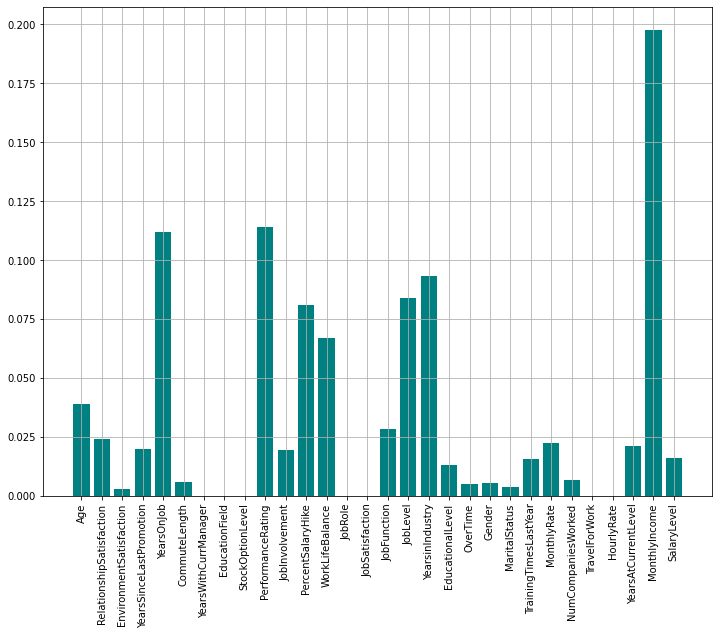

In [22]:
plt.figure(figsize=(12,9))
plt.bar(x=features, height=clf.feature_importances_)
plt.xticks(rotation=90)
plt.grid(True)
plt.show();

In [23]:
saving_path_name = "./tabnet_model/tabnet_model"
saved_filepath = clf.save_model(saving_path_name)

Successfully saved model at ./tabnet_model/tabnet_model.zip


In [37]:
ads_model = GenericModel(estimator=clf,
                artifact_dir="./artifact_dir"
            )

In [44]:
# here we should put the custom conda env
ads_model.prepare(inference_conda_env="pytorch110_p37_cpu_v1", force_overwrite=True)